# INIT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Librerias

In [ ]:
# !pip install featuretools # install the missing module

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# MODULES PATH
import sys
sys.path.append('/content/drive/MyDrive/TFM_Retail_Repo/03_Clustering')

from modules import preprocessing_module as pm
from modules import kmeans_module as km_m
from modules.get_data import get_data
from modules import feature_creation_module as fcm

## Importacion datos

In [ ]:
# Diccionario colecciones
db_collections = [
    'calendar',
    'items',
    'prices',
    'tiendas',
    'departments',
    'sales_main',
    'weekly_sales',
    'year_sales',
    'day_sales'
    ]

### CSVs

In [ ]:
df_cal = get_data('exp_calendar.csv')
df_items = get_data('exp_items.csv')
df_shops = get_data('exp_shops.csv')
df_ws = get_data('exp_weekly_sales.csv')
# df_ws = get_data('daily_sales_with_events.csv') # Vamos a probar con diarias -> peta la creacion de caracteristicas

# Renombrar columnas específicas
df_ws = df_ws.rename(columns={ #ejercicio, semana, unidades, cifra
    'ejercicio': 'year',
    'semana': 'week',
    'unidades': 'units',
    'cifra': 'raw_earn',
    })

In [ ]:
display(df_cal.head())
display(df_items.head())
display(df_shops.head())
display(df_ws.head())

,fecha,event
0,2011-02-06,SuperBowl
1,2011-08-01,Ramadan starts
2,2011-11-24,Thanksgiving
3,2012-01-01,NewYear
4,2012-02-05,SuperBowl


,item,category,department
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1


,store_code,region,store
0,NYC_1,New York,Greenwich_Village
1,NYC_2,New York,Harlem
2,NYC_3,New York,Tribeca
3,NYC_4,New York,Brooklyn
4,BOS_1,Boston,South_End


,item,store_code,year,week,units,sell_price,raw_earn
0,ACCESORIES_1_004,BOS_1,2011,4,3.0,5.77,17.32
1,ACCESORIES_1_004,BOS_2,2011,4,8.0,5.77,46.18
2,ACCESORIES_1_004,NYC_2,2011,4,9.0,5.77,51.95
3,ACCESORIES_1_004,NYC_4,2011,4,2.0,5.77,11.54
4,ACCESORIES_1_004,PHI_1,2011,4,3.0,5.77,17.32


# **CREACION CARACTERISTICAS**
___
___  
  
Creamos las caracteristicas generales y luego filtraremos para cada supuesto.

In [ ]:
# V2
fc_config = {
    'target_df': 'items',  # Nombre del DataFrame objetivo
    'agg_primitives': [
        'min',               # Mínimo
        'max',               # Máximo
        'mean',              # Promedio
        'std',               # Desviación estándar
        'sum',               # Suma
        'count'              # Totales
    ],
    'trans_primitives': [
        # 'divide_numeric',    # División entre características numéricas -> GENERA MUCHAS!!!
        'percentile'       # Porcentaje de ventas respecto a la tienda de mayor rendimiento
    ],
    'max_depth': 2         # Profundidad máxima de la generación de características
}


feature_matrix, feature_defs = fcm.create_features(df_items, df_shops, df_ws, fc_config)

In [ ]:
print(f'FeatMatrix shape : {feature_matrix.shape}')

print(f'Feat Defs length: {len(feature_defs)}')

FeatMatrix shape : (3049, 79)
Feat Defs length: 79


### Feat Descriptions

In [ ]:
# Revision definiciones caracteristicas creadas
features_descriptions = fcm.get_features_descriptions(feature_defs)

display(type(features_descriptions))

display(features_descriptions)

list

['<Feature: category>: The "category".',
 '<Feature: department>: The "department".',
 '<Feature: COUNT(sales)>: The number of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.raw_earn)>: The maximum of the "raw_earn" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.sell_price)>: The maximum of the "sell_price" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.units)>: The maximum of the "units" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.week)>: The maximum of the "week" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.year)>: The maximum of the "year" of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.raw_earn)>: The average of the "raw_earn" of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.sell_price)>: The average of the "sell_price" of all instances of "sales" for ea

**Feature selection**

> https://featuretools.alteryx.com/en/stable/api_reference.html#feature-selection  
  
- *remove_low_information_features(feature_matrix)*  
Select features that have at least 2 unique values and that are not all null

- *remove_highly_correlated_features(feature_matrix)*  
Removes columns in feature matrix that are highly correlated with another column.

- *remove_highly_null_features(feature_matrix)*  
Removes columns from a feature matrix that have higher than a set threshold of null values.

- *remove_single_value_features(feature_matrix)*  
Removes columns in feature matrix where all the values are the same.

# **PRODUCTOS: PERFORMANCE**
___
___

In [ ]:
# V3
substrings = ['raw_earn'] # Nos quedamos solo con las que afectan a los ingresos

feat_selected = fcm.select_features(features_descriptions, substrings)

print(f'Length Feats Selected: {len(feat_selected)}')
# display(feat_selected)

feature_matrix_selected = feature_matrix[feat_selected].copy()

# display(feature_matrix_selected.head(5))

# Aplicar filtros a las caracteristicas creadas
# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix_selected)

# Renombrar características si es necesario # Evitamos este paso de momento
# feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, price_range_features)
feature_matrix_renamed = filtered_feature_matrix.copy()

display(feature_matrix_renamed.head(5))

Length Feats Selected: 15
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Shape before filtering: 15
Shape after filtering: 11
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,MAX(sales.raw_earn),MEAN(sales.raw_earn),MIN(sales.raw_earn),SUM(sales.raw_earn),MAX(sales.PERCENTILE(raw_earn)),MEAN(sales.PERCENTILE(raw_earn)),STD(sales.PERCENTILE(raw_earn)),SUM(sales.PERCENTILE(raw_earn)),PERCENTILE(MAX(sales.raw_earn)),PERCENTILE(MIN(sales.raw_earn)),PERCENTILE(SUM(sales.raw_earn))
item,,,,,,,,,,,
ACCESORIES_1_001,142.82,37.996321,10.99,45025.64,0.943898,0.577755,0.214648,684.639685,0.474254,0.937193,0.515251
ACCESORIES_1_002,190.08,14.061259,2.66,26702.33,0.965846,0.274357,0.182865,521.003918,0.615612,0.419482,0.311906
ACCESORIES_1_003,63.20,8.499383,1.29,5652.09,0.814051,0.166115,0.132108,110.466577,0.137422,0.149065,0.034438
ACCESORIES_1_004,506.04,93.700155,5.01,235374.79,0.995154,0.749092,0.238713,1881.719047,0.898983,0.705477,0.944572
ACCESORIES_1_005,141.61,26.082737,3.30,55660.56,0.943140,0.455353,0.224563,971.724065,0.469334,0.499672,0.603805


In [ ]:
# Preprocesamiento
scaled_df = pm.preprocess_features(feature_matrix_renamed)

Cat cols: 0
Num cols: 11


## Kmeans

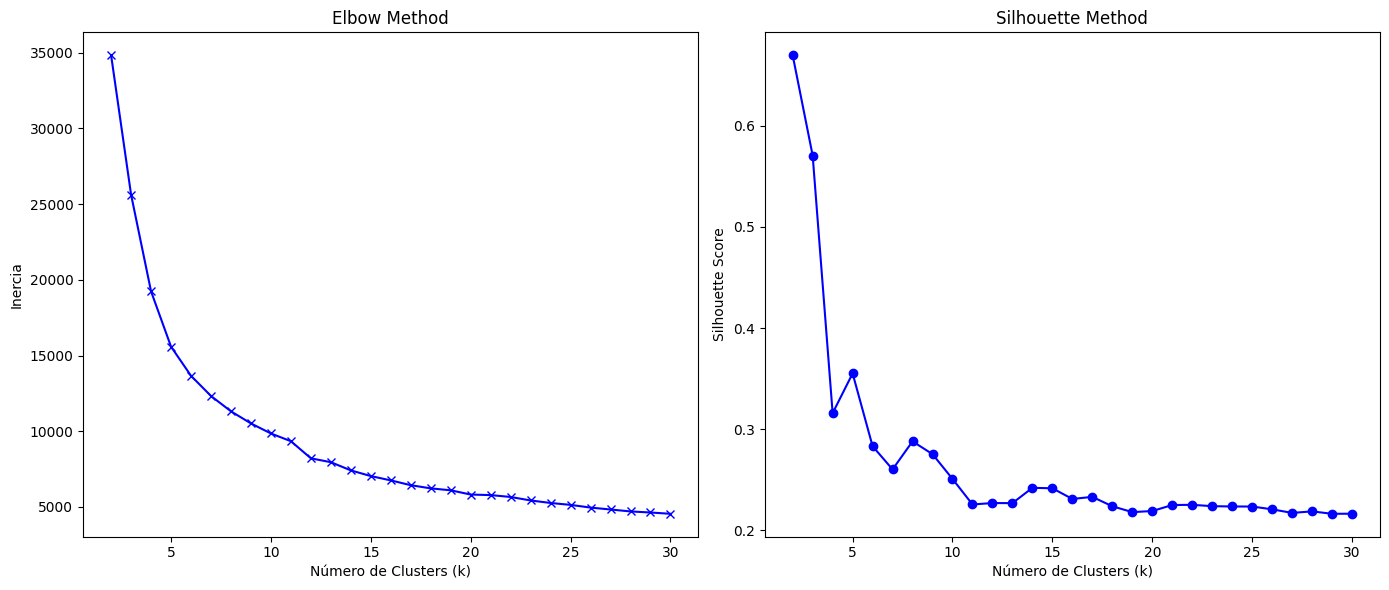

In [ ]:
# Elbow and silhouette
km_m.plot_elbow_silhouette(scaled_df, 30)

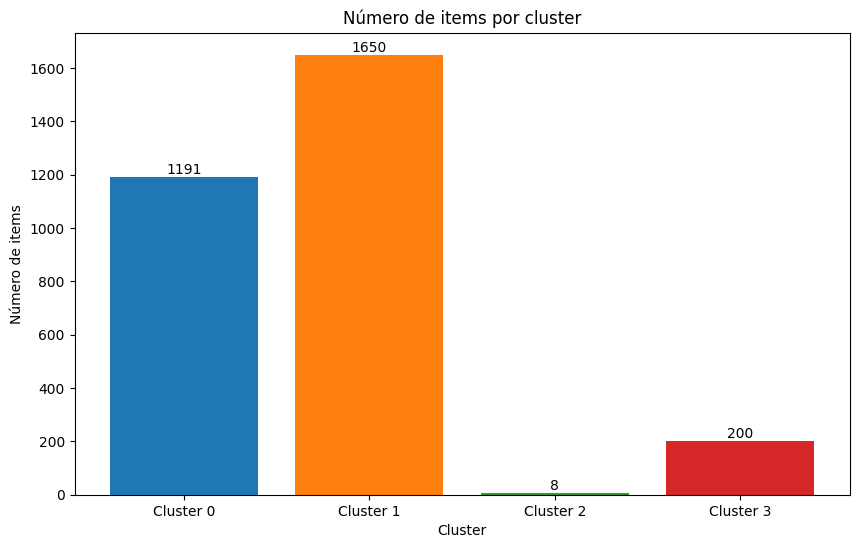

,MAX(sales.raw_earn),MEAN(sales.raw_earn),MIN(sales.raw_earn),SUM(sales.raw_earn),MAX(sales.PERCENTILE(raw_earn)),MEAN(sales.PERCENTILE(raw_earn)),STD(sales.PERCENTILE(raw_earn)),SUM(sales.PERCENTILE(raw_earn)),PERCENTILE(MAX(sales.raw_earn)),PERCENTILE(MIN(sales.raw_earn)),PERCENTILE(SUM(sales.raw_earn)),Cluster
item,,,,,,,,,,,,
ACCESORIES_1_001,142.82,37.996321,10.99,45025.64,0.943898,0.577755,0.214648,684.639685,0.474254,0.937193,0.515251,1
ACCESORIES_1_002,190.08,14.061259,2.66,26702.33,0.965846,0.274357,0.182865,521.003918,0.615612,0.419482,0.311906,0
ACCESORIES_1_003,63.20,8.499383,1.29,5652.09,0.814051,0.166115,0.132108,110.466577,0.137422,0.149065,0.034438,0
ACCESORIES_1_004,506.04,93.700155,5.01,235374.79,0.995154,0.749092,0.238713,1881.719047,0.898983,0.705477,0.944572,1
ACCESORIES_1_005,141.61,26.082737,3.30,55660.56,0.943140,0.455353,0.224563,971.724065,0.469334,0.499672,0.603805,1


In [ ]:
optimal_k = 4

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

## Analisis

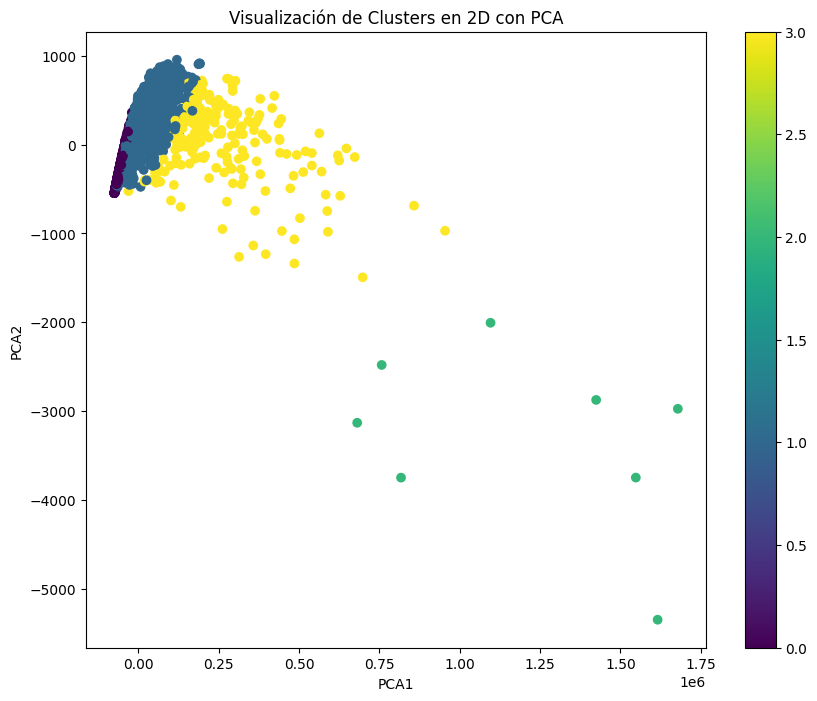

,PCA1,PCA2,Cluster
0,-30731.995616,-29.736687,1
1,-49055.552895,-151.429426,0
2,-70107.316064,-468.004951,0
3,159620.357467,559.012116,1
4,-20096.231714,222.926504,1


In [ ]:
# PCA
pca_df = km_m.pca_visualization_2d(feature_matrix_with_clusters)

display(pca_df.head())

Principal Component 1: 1.00


array([0.99998487])

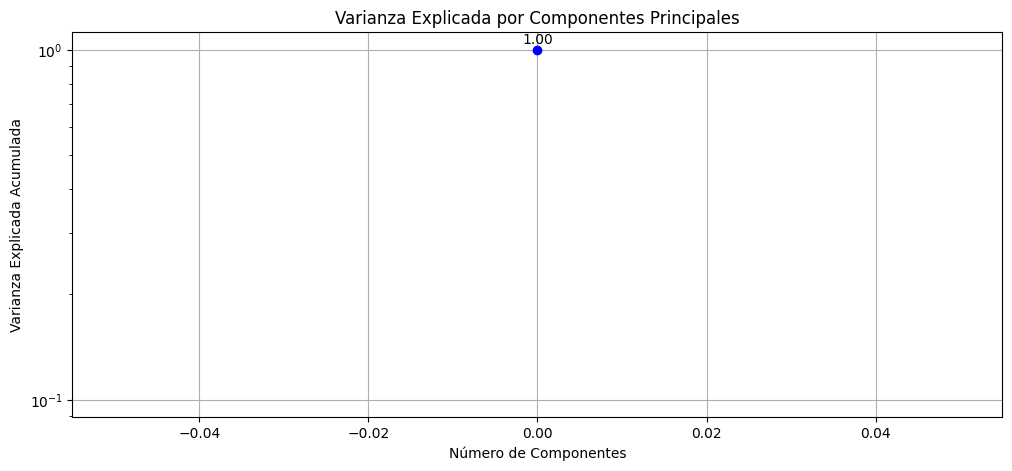

In [ ]:
explained_variance = km_m.pca_variance_plot(feature_matrix_with_clusters, 1)

display(explained_variance)

Cat cols: 0
Num cols: 11


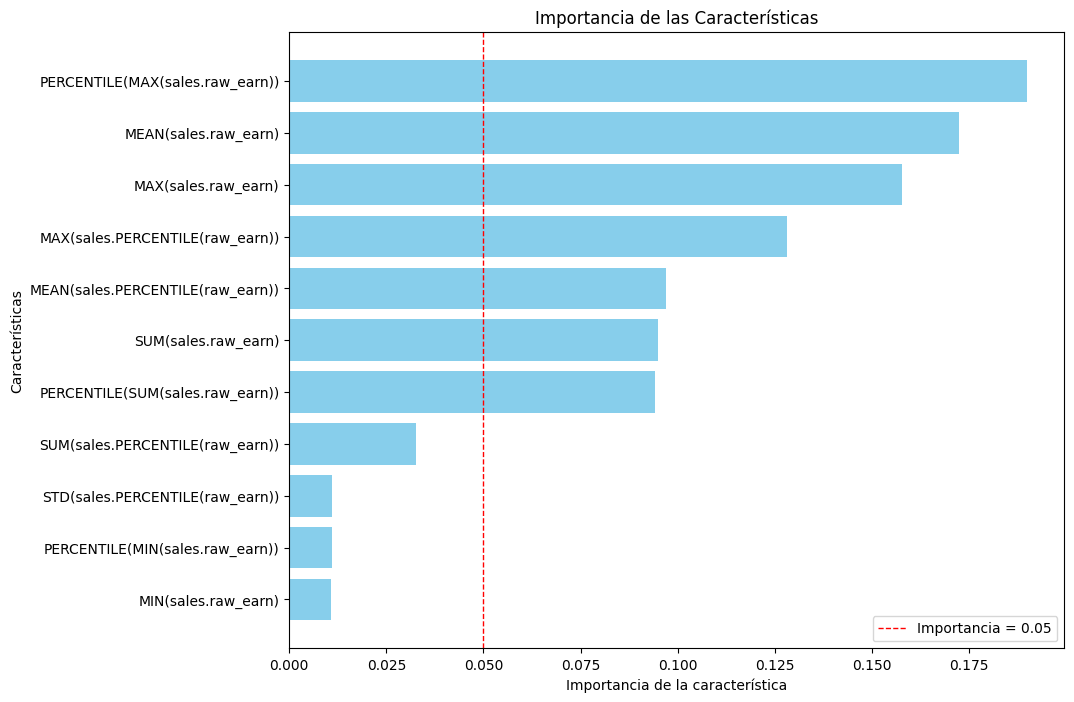

,Feature,Importance
0,PERCENTILE(MAX(sales.raw_earn)),0.190068
1,MEAN(sales.raw_earn),0.172370
2,MAX(sales.raw_earn),0.157796
3,MAX(sales.PERCENTILE(raw_earn)),0.128263
4,MEAN(sales.PERCENTILE(raw_earn)),0.097061
5,SUM(sales.raw_earn),0.095031
6,PERCENTILE(SUM(sales.raw_earn)),0.094087
7,SUM(sales.PERCENTILE(raw_earn)),0.032606
8,STD(sales.PERCENTILE(raw_earn)),0.011074
9,PERCENTILE(MIN(sales.raw_earn)),0.010990


In [ ]:
# Importancia de caracteristicas
# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo
preprocessed_df = pm.preprocess_features(feature_matrix_with_clusters[cols_to_scale])

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([preprocessed_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

IMPORTANCE_THRES=0.05
prices_importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=IMPORTANCE_THRES)

display(prices_importance_df.head(10))

## Dim redux

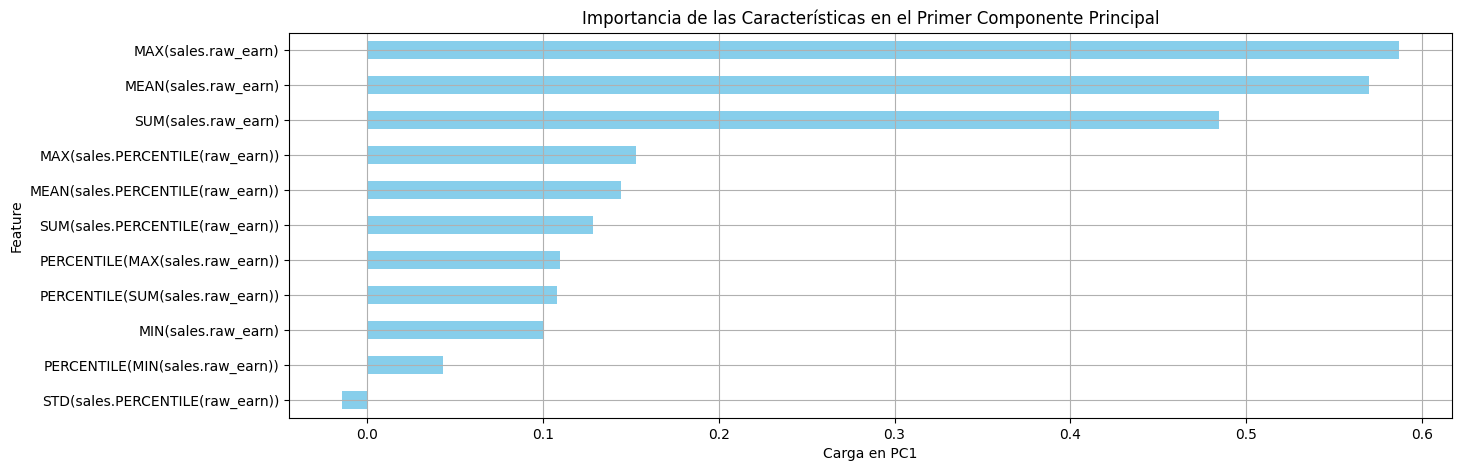

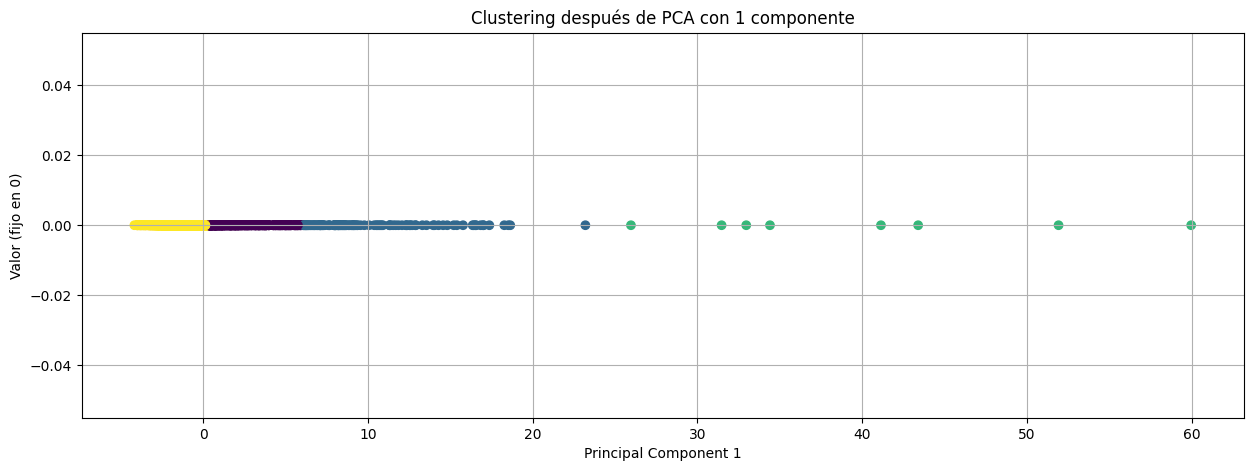

In [ ]:
# Dimension redux
pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=1)

## Descripcion

,MAX(sales.raw_earn),MEAN(sales.raw_earn),MIN(sales.raw_earn),SUM(sales.raw_earn),MAX(sales.PERCENTILE(raw_earn)),MEAN(sales.PERCENTILE(raw_earn)),STD(sales.PERCENTILE(raw_earn)),SUM(sales.PERCENTILE(raw_earn)),PERCENTILE(MAX(sales.raw_earn)),PERCENTILE(MIN(sales.raw_earn)),PERCENTILE(SUM(sales.raw_earn)),PC1,Cluster
0,-0.033346,0.388096,2.050667,0.026427,-0.035191,0.407558,0.194198,-0.057998,-0.051837,0.877055,0.030184,-0.401138,3
1,0.230190,-0.429012,-0.170667,-0.269028,0.184955,-0.603825,-0.453639,-0.275428,0.230971,-0.160750,-0.376640,-1.267324,3
2,-0.477332,-0.618886,-0.536000,-0.608455,-1.337571,-0.964651,-1.488225,-0.820925,-0.725722,-0.702827,-0.931759,-2.520922,3
3,1.992082,2.289743,0.456000,3.095729,0.478915,0.978712,0.684696,1.532608,0.797900,0.412558,0.889108,3.722253,0
4,-0.040094,-0.018616,0.000000,0.197911,-0.042793,-0.000470,0.396284,0.323462,-0.061680,0.000000,0.207349,-0.793306,3


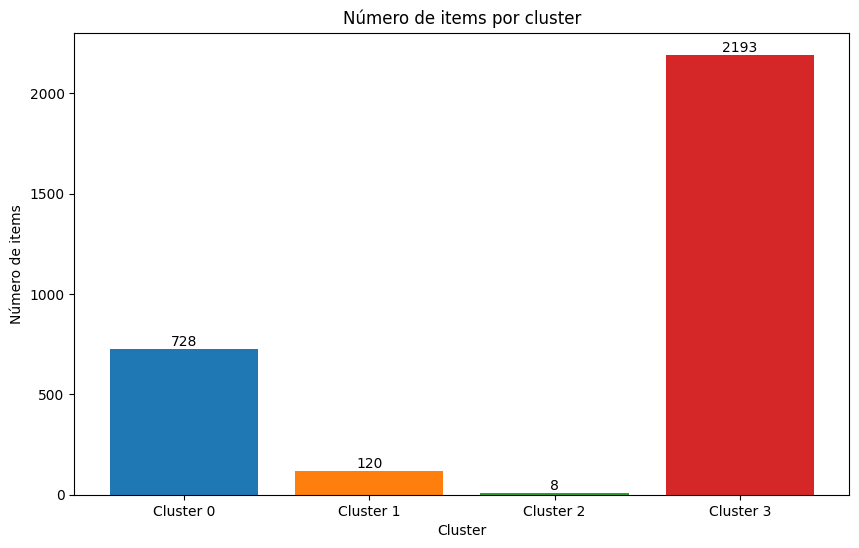

In [ ]:
# Descripcion de los clusters
# Ejecutar PCA y clustering
n_components = 1

df_with_pca, importance_df = km_m.pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=n_components)

# Mostrar el DataFrame con PCA y clustering
display(df_with_pca.head(5))

# Graficar la cantidad de items por cluster
# km_m.plot_items_per_cluster(df_with_pca)
show_clusters = km_m.plot_cluster_sizes(df_with_pca)

In [ ]:
# Seleccionamos las features según su importancia en el componente principal
importance_df_filt = importance_df[importance_df['Loading_PC1'] >= 0.05]

importance_df_filt

# Crear y mostrar descripciones de los clusters
description_df = km_m.create_cluster_descriptions(df_with_pca, importance_df_filt)
print('###########################################################')
print('Descripcion de los clusters')
print('###########################################################')
display(description_df)

###########################################################
Descripcion de los clusters
###########################################################


,3,0,1,2
MAX(sales.raw_earn),-0.143413,1.530048,6.398908,25.567111
MEAN(sales.raw_earn),-0.162812,1.464448,6.035324,26.933683
SUM(sales.raw_earn),-0.142242,1.413018,5.961999,19.909549
MAX(sales.PERCENTILE(raw_earn)),-0.722129,0.409907,0.518868,0.527169
MEAN(sales.PERCENTILE(raw_earn)),-0.270417,0.811930,1.432882,1.743683
SUM(sales.PERCENTILE(raw_earn)),-0.181266,0.812113,1.482631,1.298388
PERCENTILE(MAX(sales.raw_earn)),-0.269619,0.645787,0.943105,0.996227
PERCENTILE(SUM(sales.raw_earn)),-0.264532,0.630299,0.944029,0.997129
MIN(sales.raw_earn),0.111351,0.761282,1.197889,2.866333


In [ ]:
# Añadimos clusters a df_items
df_items = df_items.reset_index(drop=True) # Recuperamos indices originales

df_items_with_clusters = df_items.merge(df_with_pca[['Cluster']], left_index=True, right_index=True)

df_items_with_clusters.head()

,item,category,department,Cluster
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,3
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,3
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,3
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,0
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,3


In [ ]:
# Crear dataframe con las descripciones de los clusters
cluster_summary = {
    0: {
        'cluster_name': 'Moderate Performers',
        'description': 'Productos con ingresos medios y estables, con un rendimiento aceptable, pero sin alcanzar los niveles más altos. Presentan un crecimiento moderado, con baja variabilidad en sus ingresos.'
    },
    1: {
        'cluster_name': 'High Performers',
        'description': 'Productos con ingresos elevados en todas las métricas (SUM, MEAN, y MAX), lo que indica un buen desempeño continuo. Son productos que consistentemente generan buenas ventas con poca variabilidad.'
    },
    2: {
        'cluster_name': 'Top Performers with High Variability',
        'description': 'Productos con los ingresos más altos, pero con una notable variabilidad. Estos productos tienden a generar altos ingresos, pero sus ventas pueden ser impulsadas por promociones o eventos especiales.'
    },
    3: {
        'cluster_name': 'Underperformers',
        'description': 'Productos con ingresos bajos o incluso negativos en algunas métricas. Estos productos están rezagados en términos de rendimiento y podrían estar enfrentando dificultades para generar ingresos de manera constante.'
    }
}

cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')

# Asumiendo que tienes un dataframe `items_df` que tiene una columna 'cluster' con los números de cluster
# Realiza un merge con el resumen de clusters para añadir los nombres y descripciones al dataframe original
items_with_cluster_info = df_items_with_clusters.merge(cluster_summary_df, left_on='Cluster', right_index=True, how='left')

# Resultado: `items_with_cluster_info` tendrá las columnas adicionales 'cluster_name' y 'description'
display(items_with_cluster_info.head())

,item,category,department,Cluster,cluster_name,description
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,3,Underperformers,Productos con ingresos bajos o incluso negativ...
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,3,Underperformers,Productos con ingresos bajos o incluso negativ...
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,3,Underperformers,Productos con ingresos bajos o incluso negativ...
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,0,Moderate Performers,"Productos con ingresos medios y estables, con ..."
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,3,Underperformers,Productos con ingresos bajos o incluso negativ...


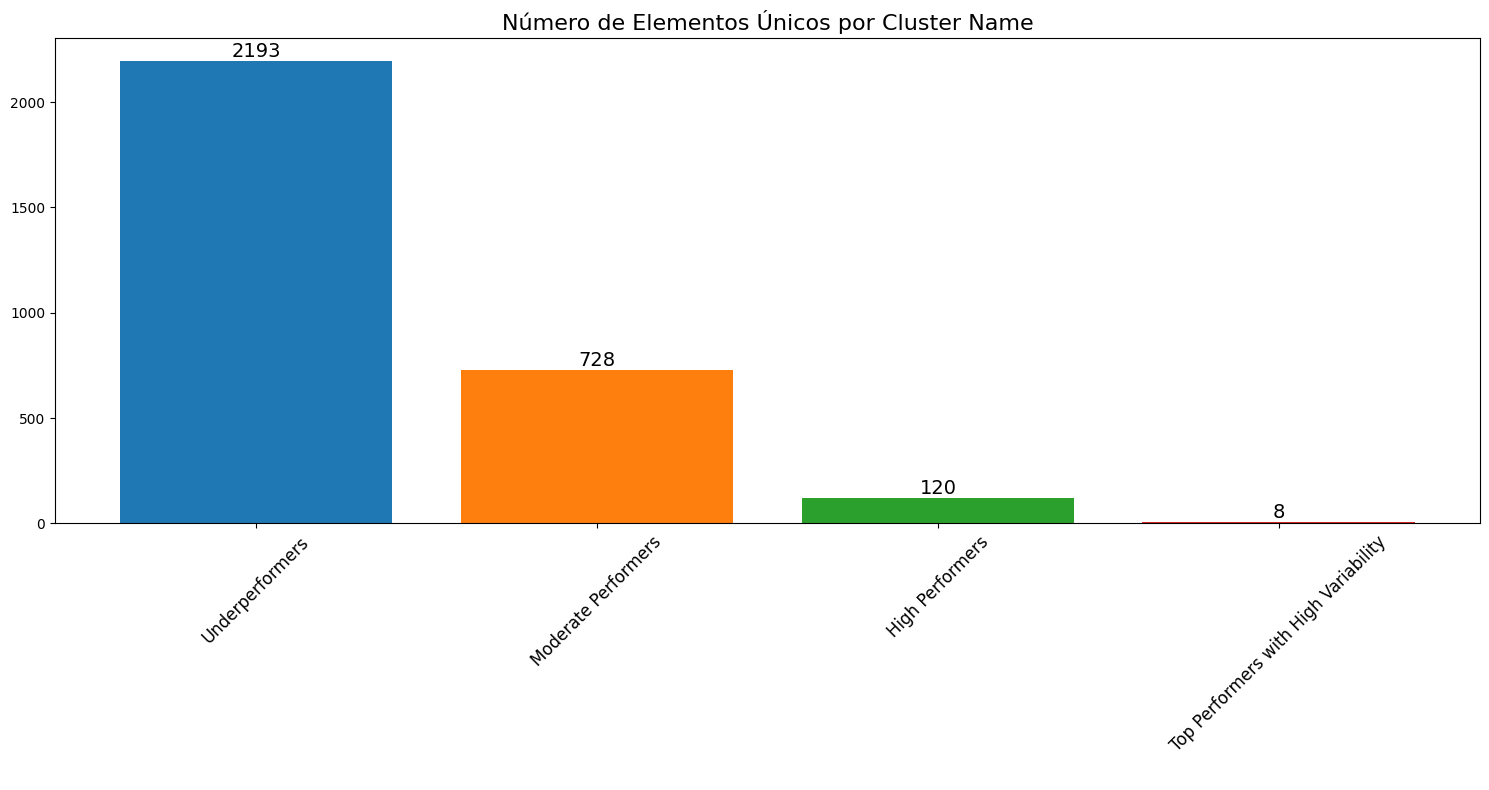

In [ ]:
km_m.plot_clusters_with_name(items_with_cluster_info)

## Guardamos csv

In [ ]:
# Guardamos df como csv
from google.colab import files

file_name = 'items_clusters_raw_earn.csv'

# # Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
# items_with_cluster_info.to_csv(file_name, index=False)

# # Descargar el archivo CSV
# files.download(file_name)

# **PRODUCTOS: RANGO DE PRECIOS**
___
___

## Selección caracteristicas

In [ ]:
# V3
substrings = ['sell_price'] # Nos quedamos solo con las que afectan al precio de venta

feat_selected = fcm.select_features(features_descriptions, substrings)

print(f'Length Feats Selected: {len(feat_selected)}')
# display(feat_selected)

feature_matrix_selected = feature_matrix[feat_selected].copy()

# display(feature_matrix_selected.head(5))

# Aplicar filtros a las caracteristicas creadas
# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix_selected)

# Renombrar características si es necesario # Evitamos este paso de momento
# feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, price_range_features)
feature_matrix_renamed = filtered_feature_matrix.copy()

display(feature_matrix_renamed.head(5))

Length Feats Selected: 15
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Shape before filtering: 15
Shape after filtering: 11
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,MAX(sales.sell_price),MEAN(sales.sell_price),MIN(sales.sell_price),STD(sales.sell_price),SUM(sales.sell_price),MAX(sales.PERCENTILE(sell_price)),MIN(sales.PERCENTILE(sell_price)),STD(sales.PERCENTILE(sell_price)),SUM(sales.PERCENTILE(sell_price)),PERCENTILE(STD(sales.sell_price)),PERCENTILE(SUM(sales.sell_price))
item,,,,,,,,,,,
ACCESORIES_1_001,12.74,11.017688,6.65,0.192594,13055.96,0.945013,0.747237,0.005579,1080.818467,0.607740,0.808462
ACCESORIES_1_002,5.28,5.276540,2.66,0.090296,10020.15,0.637007,0.273127,0.012214,1208.811852,0.369629,0.702853
ACCESORIES_1_003,3.95,3.937880,1.25,0.180185,2618.69,0.500167,0.090950,0.027354,331.387768,0.583142,0.135782
ACCESORIES_1_004,6.17,5.985088,5.01,0.266543,15034.54,0.703777,0.627013,0.020271,1729.888031,0.747458,0.856346
ACCESORIES_1_005,4.10,3.825309,2.65,0.226915,8163.21,0.509638,0.272626,0.036402,1022.399337,0.679567,0.602821


## Preprocesamiento

In [ ]:
scaled_df = pm.preprocess_features(feature_matrix_renamed)

Cat cols: 0
Num cols: 11


In [ ]:
scaled_df.head(5)

,MAX(sales.sell_price),MEAN(sales.sell_price),MIN(sales.sell_price),STD(sales.sell_price),SUM(sales.sell_price),MAX(sales.PERCENTILE(sell_price)),MIN(sales.PERCENTILE(sell_price)),STD(sales.PERCENTILE(sell_price)),SUM(sales.PERCENTILE(sell_price)),PERCENTILE(STD(sales.sell_price)),PERCENTILE(SUM(sales.sell_price))
0,1.808696,1.499780,1.144809,0.231308,0.863530,0.795535,0.977824,-0.361137,0.446484,0.215223,0.616798
1,0.186957,0.240400,0.054645,-0.236953,0.462539,0.187945,0.050306,-0.068663,0.601556,-0.261155,0.405512
2,-0.102174,-0.053249,-0.330601,0.174510,-0.515099,-0.081993,-0.306092,0.598652,-0.461504,0.166010,-0.729003
3,0.380435,0.395827,0.696721,0.569805,1.124875,0.319658,0.742625,0.286482,1.232876,0.494751,0.712598
4,-0.069565,-0.077942,0.051913,0.388411,0.217261,-0.063310,0.049328,0.997480,0.375705,0.358924,0.205381


## Kmeans

### Elbow & Silhoutte

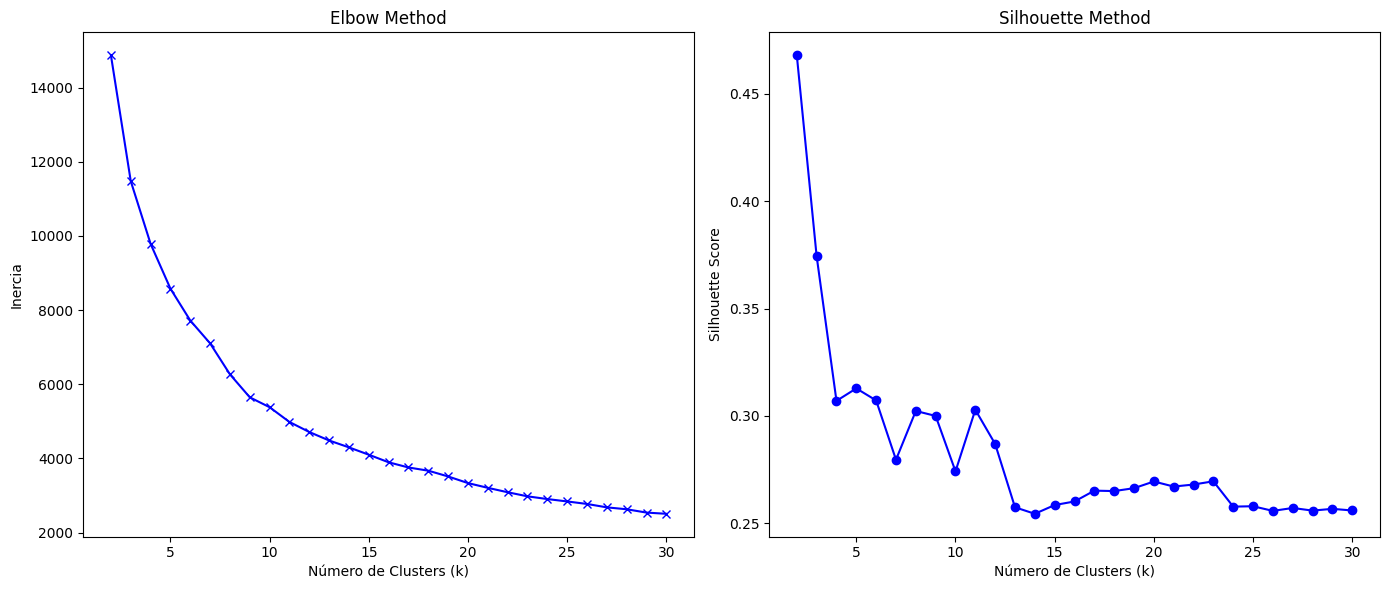

In [ ]:
km_m.plot_elbow_silhouette(scaled_df, 30)

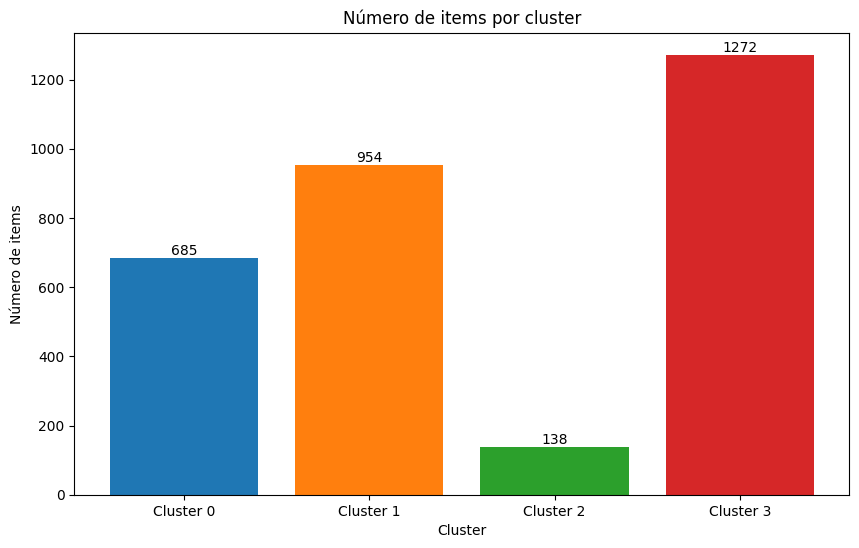

,MAX(sales.sell_price),MEAN(sales.sell_price),MIN(sales.sell_price),STD(sales.sell_price),SUM(sales.sell_price),MAX(sales.PERCENTILE(sell_price)),MIN(sales.PERCENTILE(sell_price)),STD(sales.PERCENTILE(sell_price)),SUM(sales.PERCENTILE(sell_price)),PERCENTILE(STD(sales.sell_price)),PERCENTILE(SUM(sales.sell_price)),Cluster
item,,,,,,,,,,,,
ACCESORIES_1_001,12.74,11.017688,6.65,0.192594,13055.96,0.945013,0.747237,0.005579,1080.818467,0.607740,0.808462,0
ACCESORIES_1_002,5.28,5.276540,2.66,0.090296,10020.15,0.637007,0.273127,0.012214,1208.811852,0.369629,0.702853,1
ACCESORIES_1_003,3.95,3.937880,1.25,0.180185,2618.69,0.500167,0.090950,0.027354,331.387768,0.583142,0.135782,3
ACCESORIES_1_004,6.17,5.985088,5.01,0.266543,15034.54,0.703777,0.627013,0.020271,1729.888031,0.747458,0.856346,0
ACCESORIES_1_005,4.10,3.825309,2.65,0.226915,8163.21,0.509638,0.272626,0.036402,1022.399337,0.679567,0.602821,1


In [ ]:
optimal_k = 4

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

### Analisis

#### PCAs

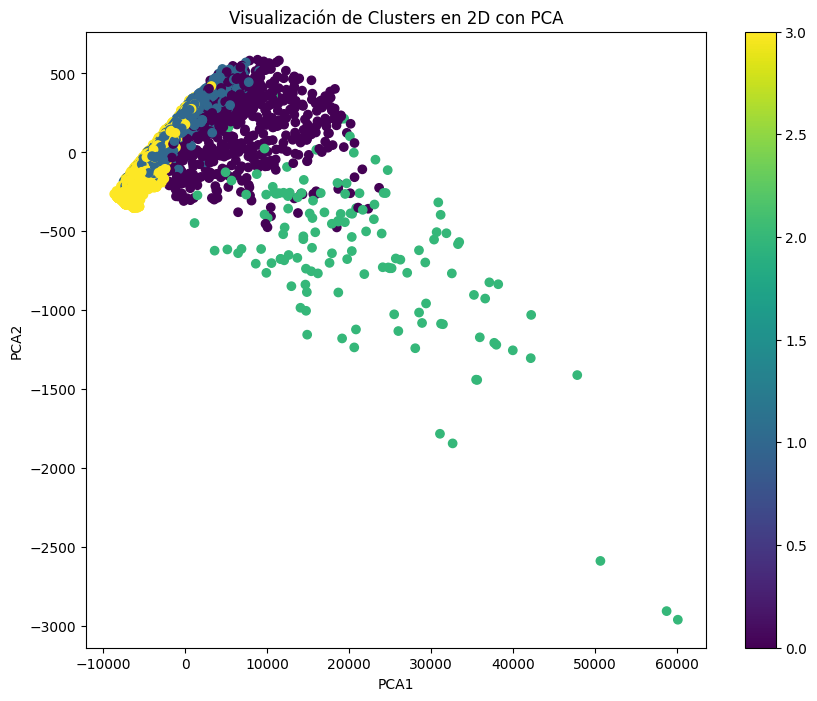

,PCA1,PCA2,Cluster
0,4326.322798,-20.941669,0
1,1305.086669,302.675103,1
2,-6137.559765,-95.445976,3
3,6342.647178,499.180666,0
4,-560.011869,236.449676,1


In [ ]:
pca_df = km_m.pca_visualization_2d(feature_matrix_with_clusters)

display(pca_df.head())

Principal Component 1: 1.00


array([0.99856547])

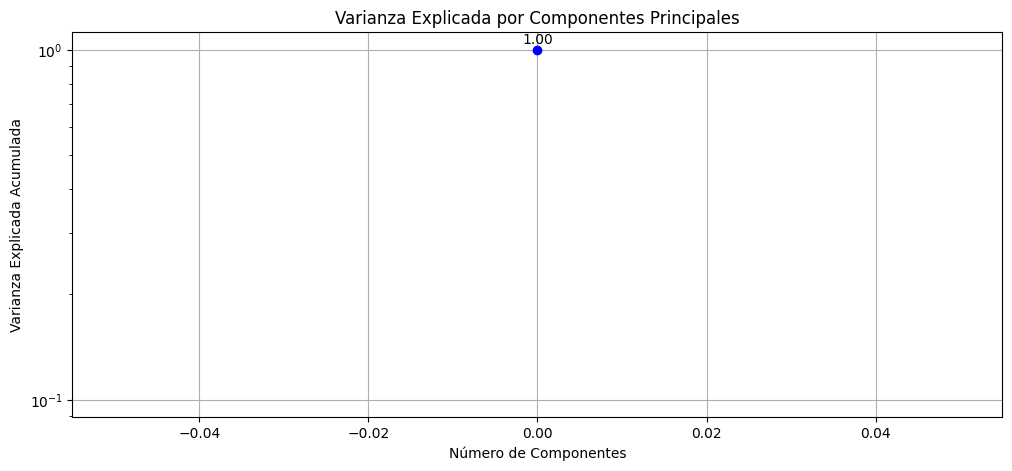

In [ ]:
explained_variance = km_m.pca_variance_plot(feature_matrix_with_clusters, 1)

display(explained_variance)

#### Importancia caracteristicas

Cat cols: 0
Num cols: 11


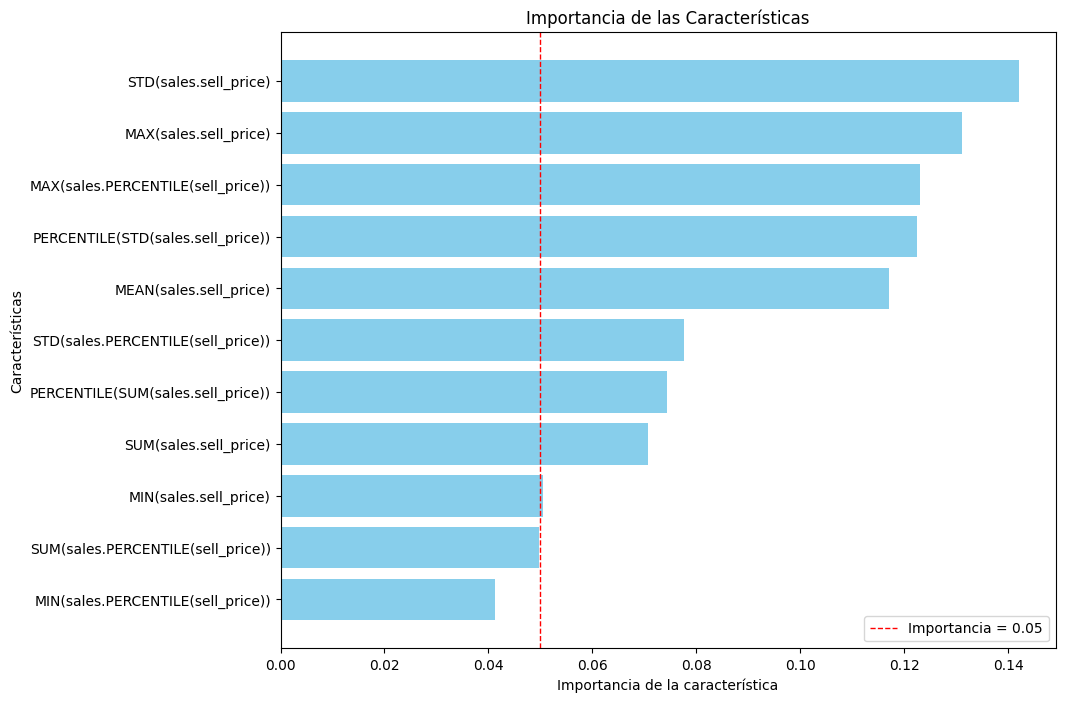

,Feature,Importance
0,STD(sales.sell_price),0.142012
1,MAX(sales.sell_price),0.131142
2,MAX(sales.PERCENTILE(sell_price)),0.122962
3,PERCENTILE(STD(sales.sell_price)),0.122516
4,MEAN(sales.sell_price),0.117151
5,STD(sales.PERCENTILE(sell_price)),0.077604
6,PERCENTILE(SUM(sales.sell_price)),0.074436
7,SUM(sales.sell_price),0.070619
8,MIN(sales.sell_price),0.050573
9,SUM(sales.PERCENTILE(sell_price)),0.049739


In [ ]:
# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo
preprocessed_df = pm.preprocess_features(feature_matrix_with_clusters[cols_to_scale])

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([preprocessed_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

IMPORTANCE_THRES=0.05
prices_importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=IMPORTANCE_THRES)

display(prices_importance_df.head(10))

### Dimension Redux

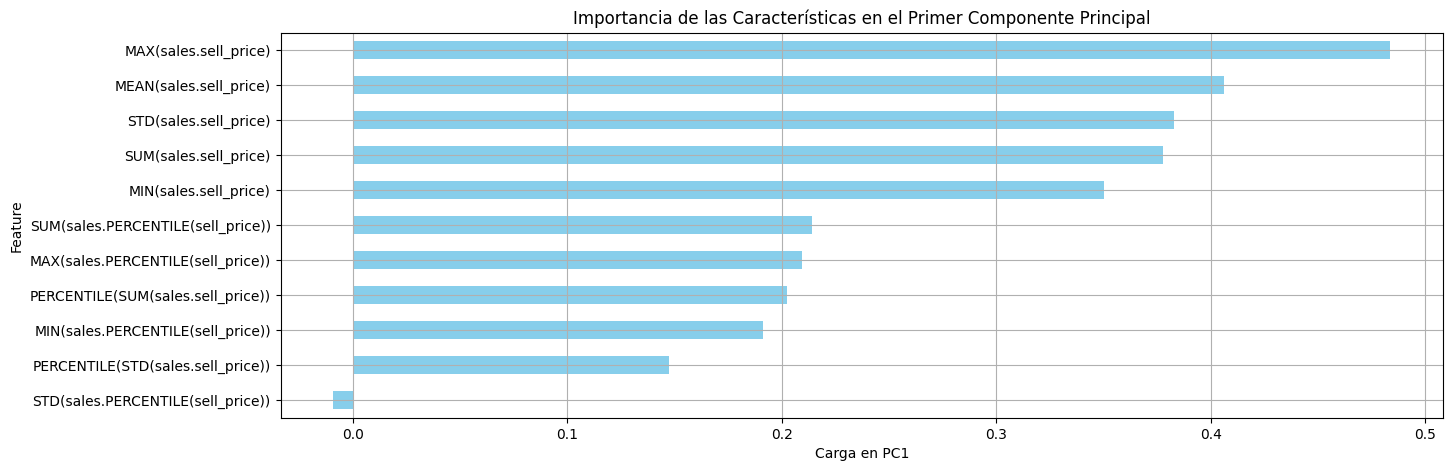

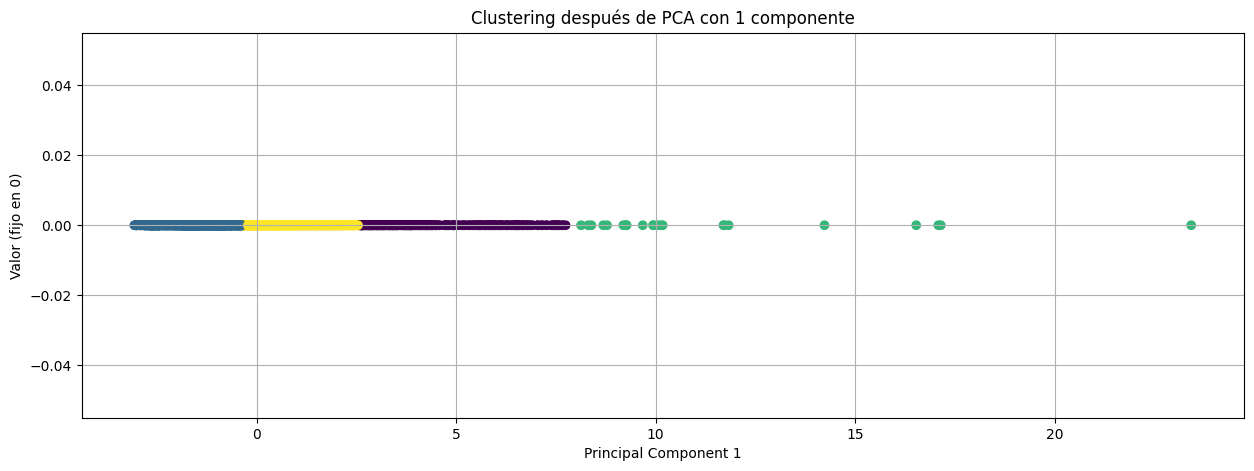

In [ ]:
pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=1)

In [ ]:
# El segundo componente es residual
# pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=2)

## Descripcion de los clusters

,MAX(sales.sell_price),MEAN(sales.sell_price),MIN(sales.sell_price),STD(sales.sell_price),SUM(sales.sell_price),MAX(sales.PERCENTILE(sell_price)),MIN(sales.PERCENTILE(sell_price)),STD(sales.PERCENTILE(sell_price)),SUM(sales.PERCENTILE(sell_price)),PERCENTILE(STD(sales.sell_price)),PERCENTILE(SUM(sales.sell_price)),PC1,Cluster
0,1.808696,1.499780,1.144809,0.231308,0.863530,0.795535,0.977824,-0.361137,0.446484,0.215223,0.616798,2.209353,3
1,0.186957,0.240400,0.054645,-0.236953,0.462539,0.187945,0.050306,-0.068663,0.601556,-0.261155,0.405512,-0.186470,3
2,-0.102174,-0.053249,-0.330601,0.174510,-0.515099,-0.081993,-0.306092,0.598652,-0.461504,0.166010,-0.729003,-1.317284,1
3,0.380435,0.395827,0.696721,0.569805,1.124875,0.319658,0.742625,0.286482,1.232876,0.494751,0.712598,1.219610,3
4,-0.069565,-0.077942,0.051913,0.388411,0.217261,-0.063310,0.049328,0.997480,0.375705,0.358924,0.205381,-0.354063,3


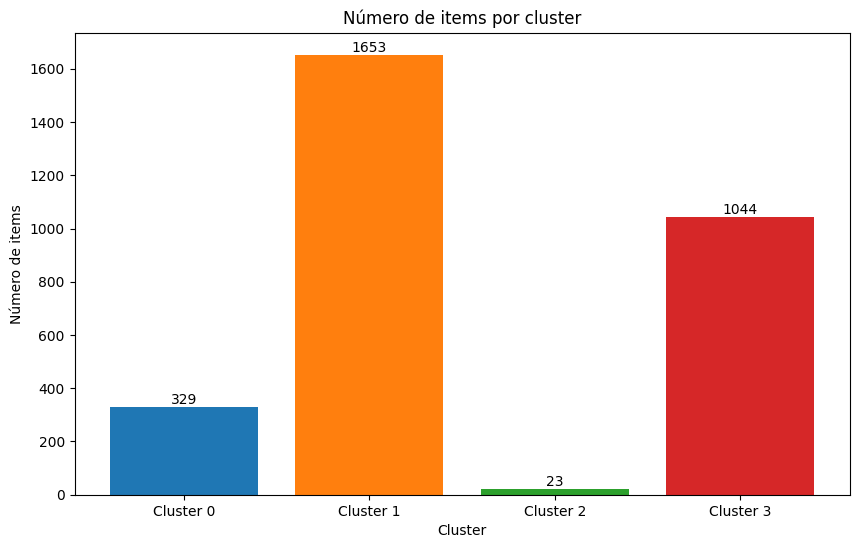

In [ ]:
# Ejecutar PCA y clustering
optimal_k = 4
n_components = 1

df_with_pca, importance_df = km_m.pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=n_components)

# Mostrar el DataFrame con PCA y clustering
display(df_with_pca.head(5))

# Graficar la cantidad de items por cluster
# km_m.plot_items_per_cluster(df_with_pca)
show_clusters = km_m.plot_cluster_sizes(df_with_pca)

### Mostrar Descripcions

In [ ]:
# Seleccionamos las features según su importancia en el componente principal
importance_df_filt = importance_df[importance_df['Loading_PC1'] >= 0.05]

# Crear y mostrar descripciones de los clusters
description_df = km_m.create_cluster_descriptions(df_with_pca, importance_df_filt)
print('###########################################################')
print('Descripcion de los clusters')
print('###########################################################')
display(description_df)

###########################################################
Descripcion de los clusters
###########################################################


,3,1,0,2
MAX(sales.sell_price),0.609491,-0.321900,2.289315,7.288280
MEAN(sales.sell_price),0.580943,-0.303939,2.142619,5.013687
STD(sales.sell_price),0.439989,-0.180353,1.854049,6.662186
SUM(sales.sell_price),0.583073,-0.296628,2.093163,3.764488
MIN(sales.sell_price),0.557055,-0.155979,1.942822,4.749228
SUM(sales.PERCENTILE(sell_price)),0.573927,-0.328042,1.013351,0.741601
MAX(sales.PERCENTILE(sell_price)),0.412539,-0.439736,0.801154,0.898683
PERCENTILE(SUM(sales.sell_price)),0.389426,-0.420222,0.810597,0.929562
MIN(sales.PERCENTILE(sell_price)),0.467907,-0.163330,1.070628,1.285097
PERCENTILE(STD(sales.sell_price)),0.196571,-0.262381,0.626702,0.970073


### Asignacion clusters a items

In [ ]:
# Añadimos clusters a df_items
df_items = df_items.reset_index(drop=True) # Recuperamos indices originales

df_items_with_clusters = df_items.merge(df_with_pca[['Cluster']], left_index=True, right_index=True)

df_items_with_clusters.head()

,item,category,department,Cluster
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,0
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,3
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,1
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,3
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,3


In [ ]:
# Crear dataframe con las descripciones de los clusters
cluster_summary = {
    0: {
        'cluster_name': 'Very High Price',
        'description': 'Productos con precios extremadamente altos en todas las métricas, con una gran variabilidad y dispersion de precios.'
    },
    1: {
        'cluster_name': 'Moderate Price with Low Variability',
        'description': 'Productos de precio moderado, con variación de precios limitada. Los productos parecen estar en un rango estable de precios medios.'
    },
    2: {
        'cluster_name': 'High Price with Stability',
        'description': 'Productos de precio alto con cierta estabilidad en los precios, pero manteniendo variación considerable en el precio máximo y promedio.'
    },
    3: {
        'cluster_name': 'Slightly Above Average Price',
        'description': 'Productos con precios ligeramente superiores al promedio, pero con una variación significativa en los precios máximos y mínimos.'
    }
}

cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')

# Realiza un merge con el resumen de clusters para añadir los nombres y descripciones al dataframe original
items_with_cluster_info = df_items_with_clusters.merge(cluster_summary_df, left_on='Cluster', right_index=True, how='left')

items_with_cluster_info = items_with_cluster_info.rename(columns={'Cluster':'cluster'})

# Resultado: `items_with_cluster_info` tendrá las columnas adicionales 'cluster_name' y 'description'
display(items_with_cluster_info.head())

,item,category,department,cluster,cluster_name,description
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,0,Very High Price,Productos con precios extremadamente altos en ...
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,3,Slightly Above Average Price,Productos con precios ligeramente superiores a...
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,1,Moderate Price with Low Variability,"Productos de precio moderado, con variación de..."
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,3,Slightly Above Average Price,Productos con precios ligeramente superiores a...
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,3,Slightly Above Average Price,Productos con precios ligeramente superiores a...


### Plot clusters con descripcion

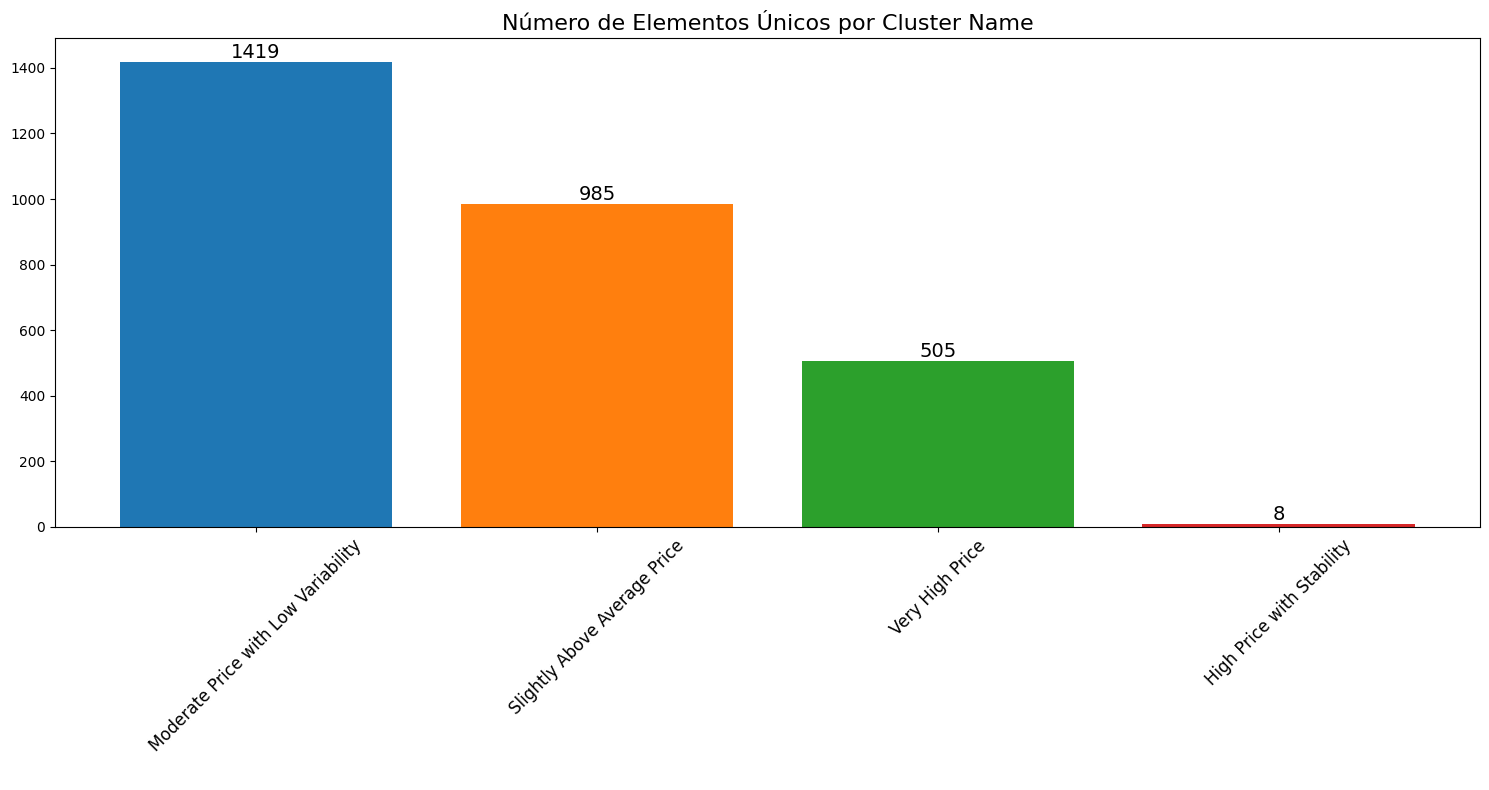

In [ ]:
km_m.plot_clusters_with_name(items_with_cluster_info)

## Guardamos CSV

In [ ]:
# Guardamos df como csv
from google.colab import files

file_name = 'items_clusters_price_range.csv'

# # Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
# items_with_cluster_info.to_csv(file_name, index=False)

# # Descargar el archivo CSV
# files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **PRODUCTOS: EVENTOS**  
  
**Efecto de eventos en ventas de productos**
___
___

## Creacion caracteristicas

In [ ]:
# Añadir año y semana a calendar para poder añadir eventos a weekly sales
df_cal['fecha'] = pd.to_datetime(df_cal['fecha'])

df_cal['year'] = df_cal['fecha'].dt.year
df_cal['week'] = df_cal['fecha'].dt.isocalendar().week

# Añadir la columna event de df_cal a df_ws usando las columnas year y week (añadir estas dos tambien a df_ws)
df_ws = df_ws.merge(df_cal[['year', 'week', 'event']], on=['year', 'week'], how='left')

# Rellenar NaN columna event de df_ws con 'None' (str)
df_ws['event'] = df_ws['event'].fillna('None')

In [ ]:
display(df_items.head())
display(df_shops.head())
display(df_ws.head())

,item,category,department
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1


,store_code,region,store
NYC_1,NYC_1,New York,Greenwich_Village
NYC_2,NYC_2,New York,Harlem
NYC_3,NYC_3,New York,Tribeca
NYC_4,NYC_4,New York,Brooklyn
BOS_1,BOS_1,Boston,South_End


,id,item,store_code,year,week,units,sell_price,raw_earn,event
0,586148,ACCESORIES_1_002,BOS_3,2012,1,2.0,5.28,10.56,None
1,586149,ACCESORIES_1_002,NYC_1,2012,1,1.0,5.28,5.28,None
2,586150,ACCESORIES_1_002,NYC_2,2012,1,1.0,5.28,5.28,None
3,586151,ACCESORIES_1_002,NYC_3,2012,1,2.0,5.28,10.56,None
4,586152,ACCESORIES_1_002,NYC_4,2012,1,1.0,5.28,5.28,None


In [ ]:
# OHE para columna event en df_ws usando sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder

# Seleccionar la columna 'event' para codificar
events = df_ws[['event']]

# Crear el OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Ajustar y transformar los eventos con OHE
event_encoded = ohe.fit_transform(events)

# Crear un DataFrame con las columnas codificadas
event_encoded_df = pd.DataFrame(event_encoded, columns=ohe.get_feature_names_out(['event']))

# Concatenar con el DataFrame original de ventas
df_ws_ohe = pd.concat([df_ws.reset_index(drop=True), event_encoded_df], axis=1)

# Ver el resultado
df_ws_ohe.head()


,id,item,store_code,year,week,units,sell_price,raw_earn,event,event_Easter,event_NewYear,event_None,event_Ramadan starts,event_SuperBowl,event_Thanksgiving
0,586148,ACCESORIES_1_002,BOS_3,2012,1,2.0,5.28,10.56,None,0.0,0.0,1.0,0.0,0.0,0.0
1,586149,ACCESORIES_1_002,NYC_1,2012,1,1.0,5.28,5.28,None,0.0,0.0,1.0,0.0,0.0,0.0
2,586150,ACCESORIES_1_002,NYC_2,2012,1,1.0,5.28,5.28,None,0.0,0.0,1.0,0.0,0.0,0.0
3,586151,ACCESORIES_1_002,NYC_3,2012,1,2.0,5.28,10.56,None,0.0,0.0,1.0,0.0,0.0,0.0
4,586152,ACCESORIES_1_002,NYC_4,2012,1,1.0,5.28,5.28,None,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
import featuretools as ft

# Crear un EntitySet
es = ft.EntitySet(id='sales_data')

# Agregar entidades
es = es.add_dataframe(dataframe_name="items", dataframe=df_items, index="item")
es = es.add_dataframe(dataframe_name="shops", dataframe=df_shops, index="store_code")
es = es.add_dataframe(dataframe_name="sales", dataframe=df_ws_ohe, index="id",
                      time_index="week",
                      secondary_time_index={'year': ['units', 'sell_price', 'raw_earn']})

# Definir relaciones
es = es.add_relationship("items", "item", "sales", "item")
es = es.add_relationship("shops", "store_code", "sales", "store_code")

# Generar características automáticas, ahora centradas en "items"
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_dataframe_name="items",  # Objetivo: productos
                                      agg_primitives=[
                                          "sum", "mean", "count"  # Agregación sobre ventas
                                      ],
                                      trans_primitives=["year"],  # Primitivas de transformación, usando 'year'
                                      max_depth=2)

feature_matrix.head()

## Selección caracteristicas

In [ ]:
# Revision definiciones caracteristicas creadas
features_descriptions = fcm.get_features_descriptions(feature_defs)

display(type(features_descriptions))

display(features_descriptions)

list

['<Feature: category>: The "category".',
 '<Feature: department>: The "department".',
 '<Feature: COUNT(sales)>: The number of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.event_Easter)>: The average of the "event_Easter" of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.event_NewYear)>: The average of the "event_NewYear" of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.event_None)>: The average of the "event_None" of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.event_Ramadan starts)>: The average of the "event_Ramadan starts" of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.event_SuperBowl)>: The average of the "event_SuperBowl" of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.event_Thanksgiving)>: The average of the "event_Thanksgiving" of all instances of "sales" for each "item" in "items".',


In [ ]:
# V3
substrings = ['event', 'raw_earn'] # Nos quedamos solo con las que afectan a ventas

print(f'Length All features: {len(features_descriptions)}')

feat_selected = fcm.select_features(features_descriptions, substrings)

print(f'Length Feats Selected: {len(feat_selected)}')
# display(feat_selected)

feature_matrix_selected = feature_matrix[feat_selected].copy()

# display(feature_matrix_selected.head(5))

# Aplicar filtros a las caracteristicas creadas
# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix_selected)

# Renombrar características si es necesario # Evitamos este paso de momento
# feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, price_range_features)
feature_matrix_renamed = filtered_feature_matrix.copy()

display(feature_matrix_renamed.head(5))

Length All features: 25
Length Feats Selected: 14
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Shape before filtering: 14
Shape after filtering: 14
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,MEAN(sales.event_Easter),MEAN(sales.event_NewYear),MEAN(sales.event_None),MEAN(sales.event_Ramadan starts),MEAN(sales.event_SuperBowl),MEAN(sales.event_Thanksgiving),MEAN(sales.raw_earn),SUM(sales.event_Easter),SUM(sales.event_NewYear),SUM(sales.event_None),SUM(sales.event_Ramadan starts),SUM(sales.event_SuperBowl),SUM(sales.event_Thanksgiving),SUM(sales.raw_earn)
item,,,,,,,,,,,,,,
ACCESORIES_1_001,0.020253,0.018565,0.904641,0.016034,0.020253,0.020253,37.996321,24.0,22.0,1072.0,19.0,24.0,24.0,45025.64
ACCESORIES_1_002,0.017378,0.014745,0.909953,0.021590,0.017904,0.018431,14.061259,33.0,28.0,1728.0,41.0,34.0,35.0,26702.33
ACCESORIES_1_003,0.028571,0.025564,0.896241,0.018045,0.021053,0.010526,8.499383,19.0,17.0,596.0,12.0,14.0,7.0,5652.09
ACCESORIES_1_004,0.018312,0.018710,0.908838,0.015924,0.021099,0.017118,93.700155,46.0,47.0,2283.0,40.0,53.0,43.0,235374.79
ACCESORIES_1_005,0.018276,0.020150,0.902530,0.018276,0.021087,0.019681,26.082737,39.0,43.0,1926.0,39.0,45.0,42.0,55660.56


## Preprocesamiento

In [ ]:
scaled_df = pm.preprocess_features(feature_matrix_renamed)

scaled_df.head()

Cat cols: 0
Num cols: 14


,MEAN(sales.event_Easter),MEAN(sales.event_NewYear),MEAN(sales.event_None),MEAN(sales.event_Ramadan starts),MEAN(sales.event_SuperBowl),MEAN(sales.event_Thanksgiving),MEAN(sales.raw_earn),SUM(sales.event_Easter),SUM(sales.event_NewYear),SUM(sales.event_None),SUM(sales.event_Ramadan starts),SUM(sales.event_SuperBowl),SUM(sales.event_Thanksgiving),SUM(sales.raw_earn)
0,0.118297,-0.118405,0.149200,-0.586754,-0.289933,0.581634,0.388096,-0.6250,-0.578947,-0.496732,-0.523810,-0.48,-0.30,0.026427
1,-0.572152,-0.752724,0.709012,1.006050,-0.878360,0.037087,-0.429012,-0.0625,-0.263158,0.217865,0.523810,-0.08,0.25,-0.269028
2,2.115563,1.043470,-0.736248,-0.010192,-0.089666,-2.324805,-0.618886,-0.9375,-0.842105,-1.015251,-0.857143,-0.88,-1.15,-0.608455
3,-0.347764,-0.094367,0.591487,-0.618340,-0.078119,-0.355221,2.289743,0.7500,0.736842,0.822440,0.476190,0.68,0.65,3.095729
4,-0.356543,0.144659,-0.073290,0.055860,-0.081017,0.410772,-0.018616,0.3125,0.526316,0.433551,0.428571,0.36,0.60,0.197911


## Kmeans

### Elbow & Silhoutte

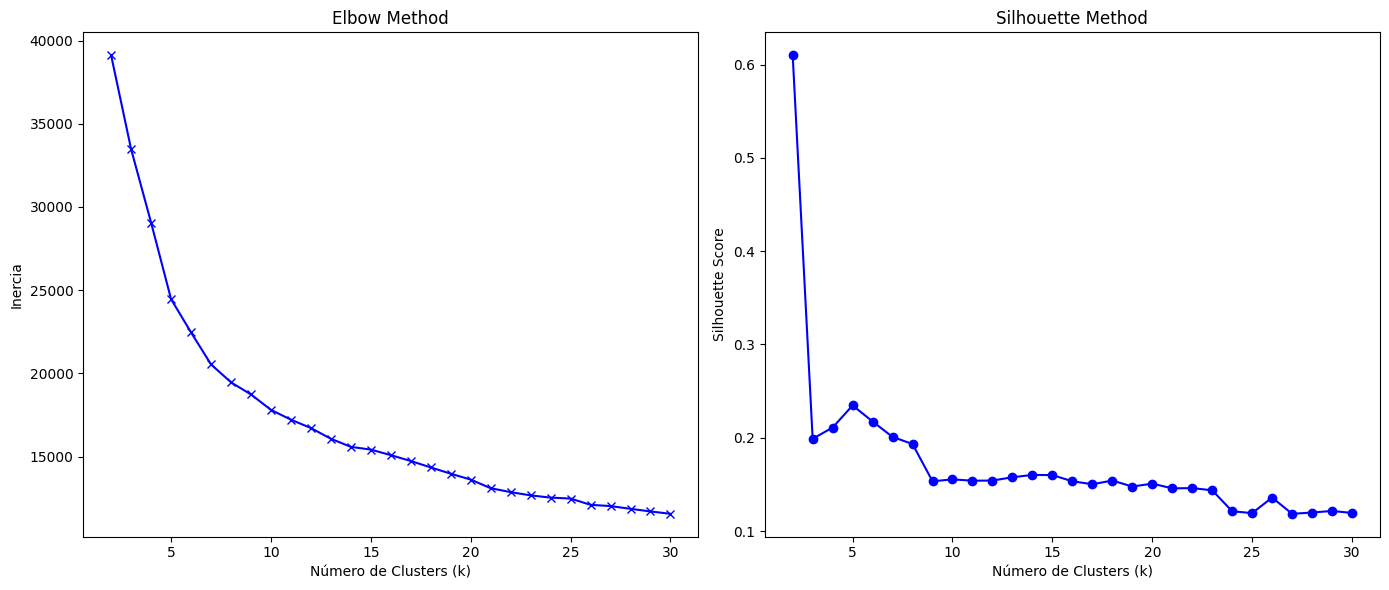

In [ ]:
km_m.plot_elbow_silhouette(scaled_df, 30)

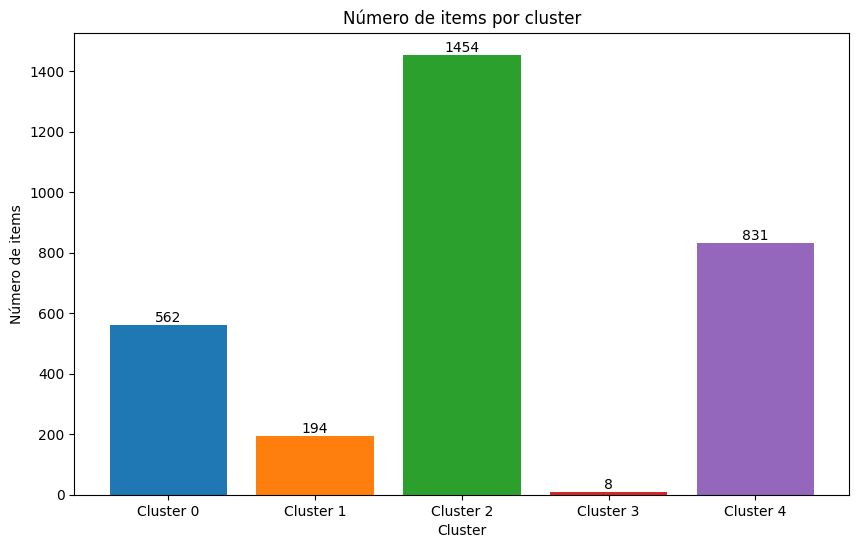

,MEAN(sales.event_Easter),MEAN(sales.event_NewYear),MEAN(sales.event_None),MEAN(sales.event_Ramadan starts),MEAN(sales.event_SuperBowl),MEAN(sales.event_Thanksgiving),MEAN(sales.raw_earn),SUM(sales.event_Easter),SUM(sales.event_NewYear),SUM(sales.event_None),SUM(sales.event_Ramadan starts),SUM(sales.event_SuperBowl),SUM(sales.event_Thanksgiving),SUM(sales.raw_earn),Cluster
item,,,,,,,,,,,,,,,
ACCESORIES_1_001,0.020253,0.018565,0.904641,0.016034,0.020253,0.020253,37.996321,24.0,22.0,1072.0,19.0,24.0,24.0,45025.64,4
ACCESORIES_1_002,0.017378,0.014745,0.909953,0.021590,0.017904,0.018431,14.061259,33.0,28.0,1728.0,41.0,34.0,35.0,26702.33,2
ACCESORIES_1_003,0.028571,0.025564,0.896241,0.018045,0.021053,0.010526,8.499383,19.0,17.0,596.0,12.0,14.0,7.0,5652.09,0
ACCESORIES_1_004,0.018312,0.018710,0.908838,0.015924,0.021099,0.017118,93.700155,46.0,47.0,2283.0,40.0,53.0,43.0,235374.79,2
ACCESORIES_1_005,0.018276,0.020150,0.902530,0.018276,0.021087,0.019681,26.082737,39.0,43.0,1926.0,39.0,45.0,42.0,55660.56,2


In [ ]:
# Apreciamos varias opciones 4 o 5
optimal_k = 5

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

### Analisis

#### PCAs

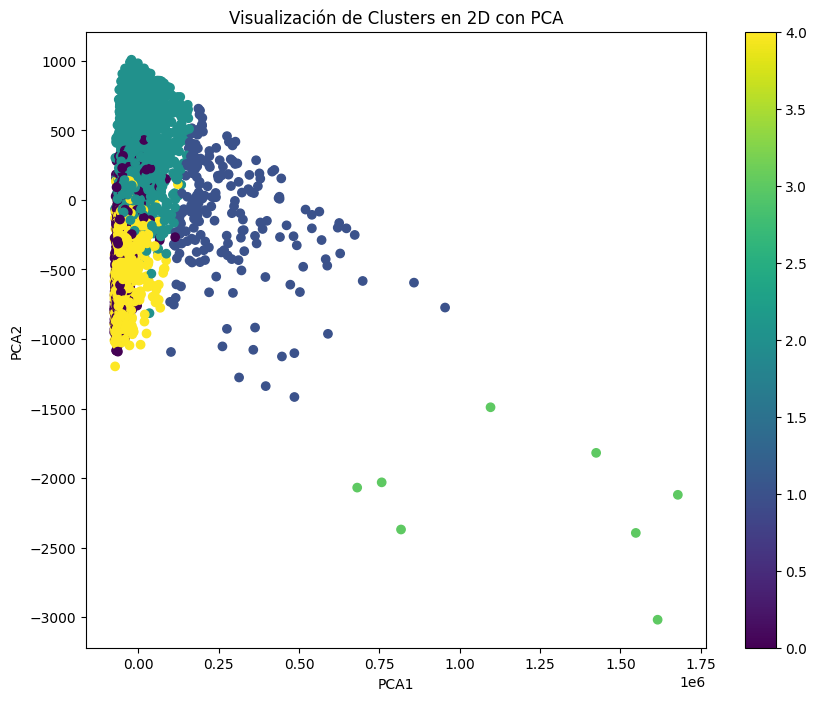

,PCA1,PCA2,Cluster
0,-30732.239053,-357.995690,4
1,-49054.302784,332.846598,2
2,-70106.618404,-760.640095,0
3,159618.844673,499.863605,2
4,-20095.750390,477.391221,2


In [ ]:
pca_df = km_m.pca_visualization_2d(feature_matrix_with_clusters)

display(pca_df.head())

Principal Component 1: 1.00


array([0.9999794])

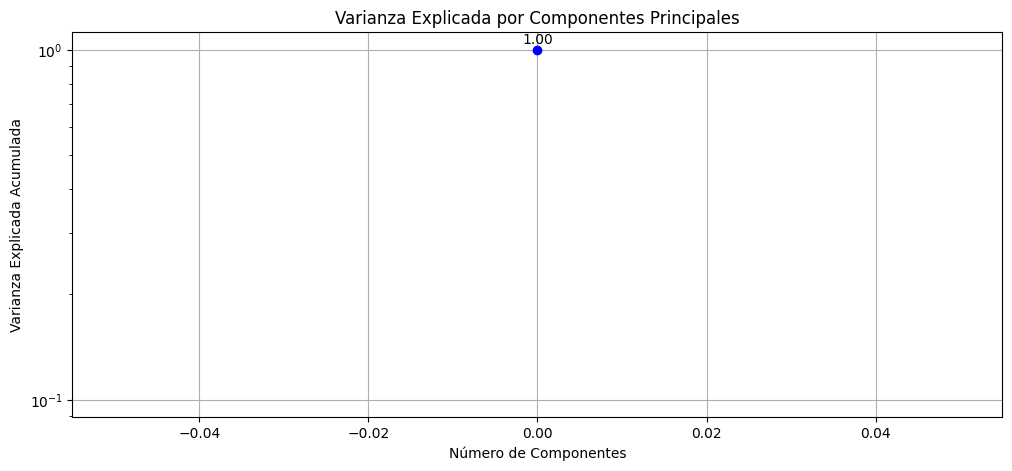

In [ ]:
explained_variance = km_m.pca_variance_plot(feature_matrix_with_clusters, 1)

display(explained_variance)

#### Importancia caracteristicas

Cat cols: 0
Num cols: 14


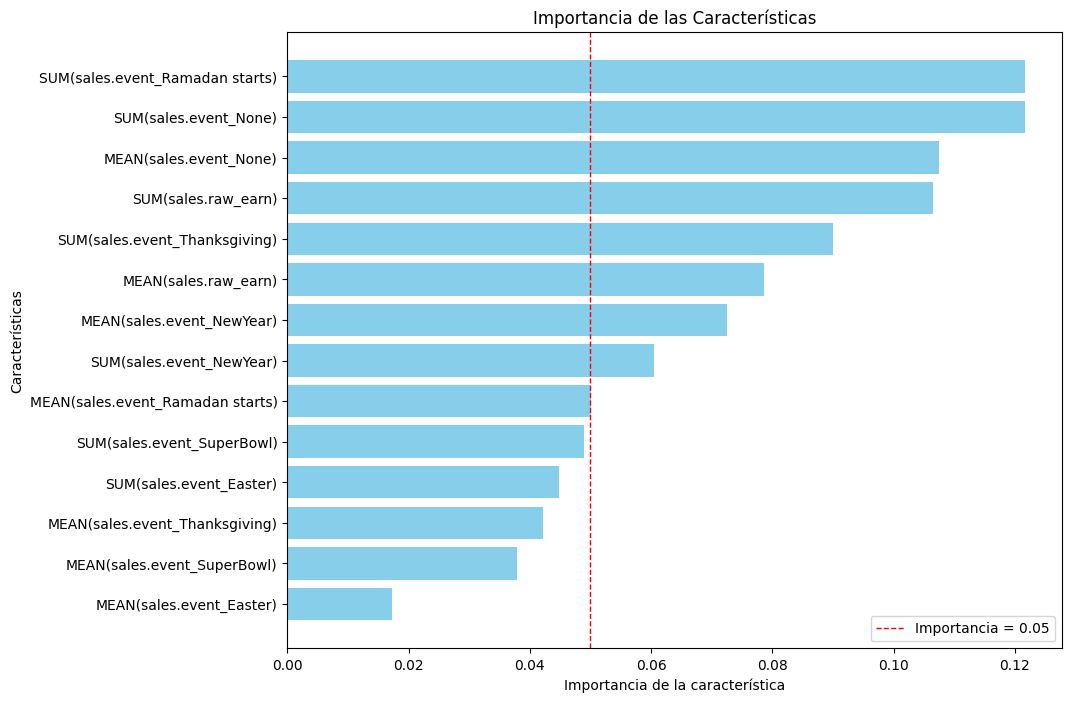

,Feature,Importance
0,SUM(sales.event_Ramadan starts),0.121719
1,SUM(sales.event_None),0.121583
2,MEAN(sales.event_None),0.107402
3,SUM(sales.raw_earn),0.106517
4,SUM(sales.event_Thanksgiving),0.090021
5,MEAN(sales.raw_earn),0.078552
6,MEAN(sales.event_NewYear),0.072562
7,SUM(sales.event_NewYear),0.060551
8,MEAN(sales.event_Ramadan starts),0.050070
9,SUM(sales.event_SuperBowl),0.048887


In [ ]:
# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo
preprocessed_df = pm.preprocess_features(feature_matrix_with_clusters[cols_to_scale])

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([preprocessed_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

IMPORTANCE_THRES=0.05
prices_importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=IMPORTANCE_THRES)

display(prices_importance_df.head(10))

### Dimension Redux

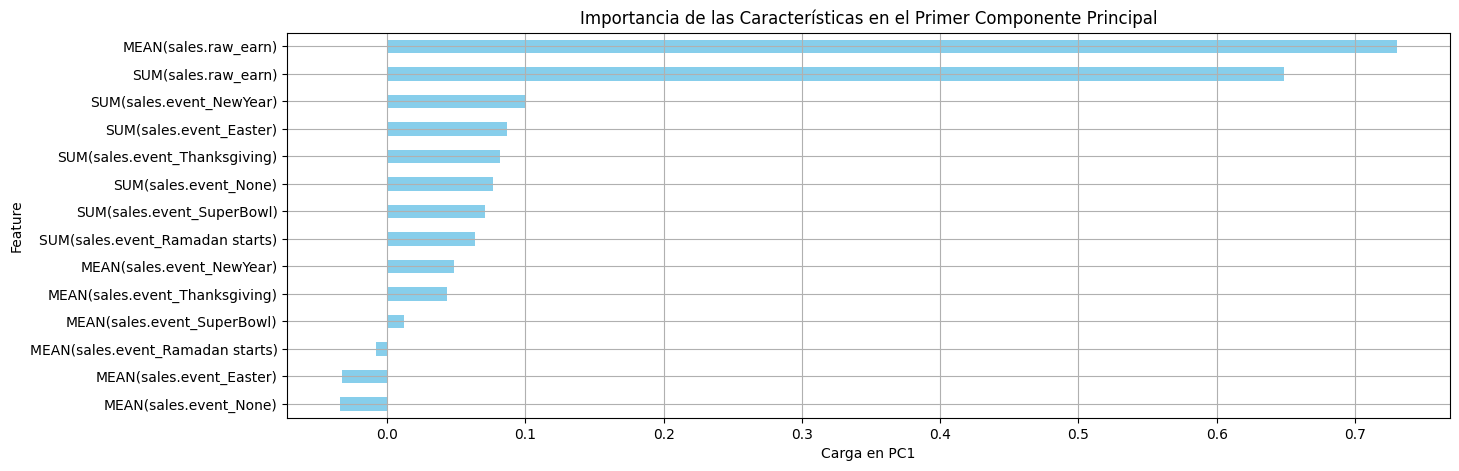

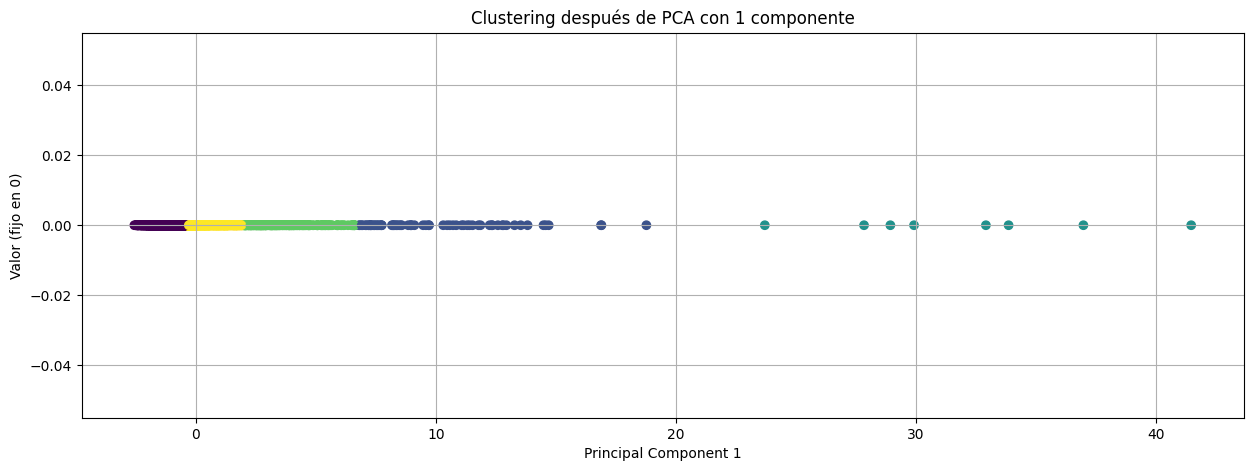

In [ ]:
pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=1)

In [ ]:
# El segundo componente es residual
# pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=2)

## Descripcion de los clusters

,MEAN(sales.event_Easter),MEAN(sales.event_NewYear),MEAN(sales.event_None),MEAN(sales.event_Ramadan starts),MEAN(sales.event_SuperBowl),MEAN(sales.event_Thanksgiving),MEAN(sales.raw_earn),SUM(sales.event_Easter),SUM(sales.event_NewYear),SUM(sales.event_None),SUM(sales.event_Ramadan starts),SUM(sales.event_SuperBowl),SUM(sales.event_Thanksgiving),SUM(sales.raw_earn),PC1,Cluster
0,0.118297,-0.118405,0.149200,-0.586754,-0.289933,0.581634,0.388096,-0.6250,-0.578947,-0.496732,-0.523810,-0.48,-0.30,0.026427,-0.635422,0
1,-0.572152,-0.752724,0.709012,1.006050,-0.878360,0.037087,-0.429012,-0.0625,-0.263158,0.217865,0.523810,-0.08,0.25,-0.269028,-1.219241,0
2,2.115563,1.043470,-0.736248,-0.010192,-0.089666,-2.324805,-0.618886,-0.9375,-0.842105,-1.015251,-0.857143,-0.88,-1.15,-0.608455,-2.101345,0
3,-0.347764,-0.094367,0.591487,-0.618340,-0.078119,-0.355221,2.289743,0.7500,0.736842,0.822440,0.476190,0.68,0.65,3.095729,3.283995,3
4,-0.356543,0.144659,-0.073290,0.055860,-0.081017,0.410772,-0.018616,0.3125,0.526316,0.433551,0.428571,0.36,0.60,0.197911,-0.338256,4


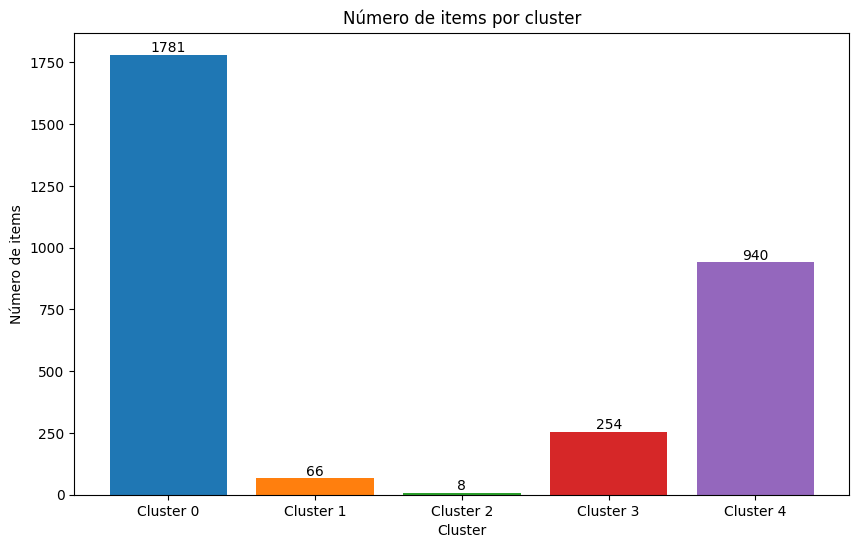

In [ ]:
# Ejecutar PCA y clustering
optimal_k = 5
n_components = 1

df_with_pca, importance_df = km_m.pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=n_components)

# Mostrar el DataFrame con PCA y clustering
display(df_with_pca.head(5))

# Graficar la cantidad de items por cluster
# km_m.plot_items_per_cluster(df_with_pca)
show_clusters = km_m.plot_cluster_sizes(df_with_pca)

### Mostrar Descripcions

In [ ]:
# Seleccionamos las features según su importancia en el componente principal
importance_df_filt = importance_df[importance_df['Loading_PC1'] >= 0.05]

importance_df_filt

# Crear y mostrar descripciones de los clusters
description_df = km_m.create_cluster_descriptions(df_with_pca, importance_df_filt)
print('###########################################################')
print('Descripcion de los clusters')
print('###########################################################')
display(description_df)

###########################################################
Descripcion de los clusters
###########################################################


,0,3,4,1,2
MEAN(sales.raw_earn),-0.248575,2.940950,0.670343,7.559069,26.933683
SUM(sales.raw_earn),-0.273698,2.918931,0.718632,7.616904,19.909549
SUM(sales.event_NewYear),-0.381483,0.479072,0.336842,0.607656,0.210526
SUM(sales.event_Easter),-0.372263,0.384843,0.293085,0.444129,0.156250
SUM(sales.event_Thanksgiving),-0.290707,0.405709,0.330532,0.566667,0.087500
SUM(sales.event_None),-0.302265,0.358349,0.296623,0.466429,0.043164
SUM(sales.event_SuperBowl),-0.273195,0.331811,0.280723,0.429697,0.085000
SUM(sales.event_Ramadan starts),-0.244619,0.323397,0.266261,0.348485,-0.011905


In [ ]:
description_df[sorted(description_df.columns)]

,0,1,2,3,4
MEAN(sales.raw_earn),-0.248575,7.559069,26.933683,2.940950,0.670343
SUM(sales.raw_earn),-0.273698,7.616904,19.909549,2.918931,0.718632
SUM(sales.event_NewYear),-0.381483,0.607656,0.210526,0.479072,0.336842
SUM(sales.event_Easter),-0.372263,0.444129,0.156250,0.384843,0.293085
SUM(sales.event_Thanksgiving),-0.290707,0.566667,0.087500,0.405709,0.330532
SUM(sales.event_None),-0.302265,0.466429,0.043164,0.358349,0.296623
SUM(sales.event_SuperBowl),-0.273195,0.429697,0.085000,0.331811,0.280723
SUM(sales.event_Ramadan starts),-0.244619,0.348485,-0.011905,0.323397,0.266261


### Asignacion clusters a items

In [ ]:
# Añadimos clusters a df_items
df_items = df_items.reset_index(drop=True) # Recuperamos indices originales

df_items_with_clusters = df_items.merge(df_with_pca[['Cluster']], left_index=True, right_index=True)

df_items_with_clusters.head()

,item,category,department,Cluster
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,0
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,0
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,0
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,3
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,4


In [ ]:
# Crear dataframe con las descripciones de los clusters
cluster_summary = {
    0: {
        'cluster_name': 'Negative Impact Products',
        'description': 'Productos que presentan un impacto negativo en ingresos durante la mayoría de los eventos, con una ligera caída en las ventas durante festividades como el Año Nuevo y la Pascua.'
    },
    1: {
        'cluster_name': 'High Seasonal Performance',
        'description': 'Productos con ingresos muy elevados, especialmente durante eventos importantes como el Año Nuevo y el Super Bowl. Su desempeño está fuertemente ligado a eventos específicos.'
    },
    2: {
        'cluster_name': 'Event-Driven Premium Products',
        'description': 'Productos con ingresos muy altos y sensibilidad a eventos como el Año Nuevo y el Super Bowl. Estos productos tienden a rendir mejor en fechas especiales.'
    },
    3: {
        'cluster_name': 'Moderate Event Sensitivity',
        'description': 'Productos que muestran un desempeño positivo moderado durante eventos, sin grandes variaciones. Están ligeramente influenciados por eventos como el Año Nuevo, Pascua y el Super Bowl.'
    },
    4: {
        'cluster_name': 'Event-Resistant Products',
        'description': 'Productos con un impacto marginalmente positivo durante eventos, pero que no dependen fuertemente de los mismos. Muestran estabilidad en ventas, independientemente de festividades.'
    }
}

cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')

# Asumiendo que tienes un dataframe `items_df` que tiene una columna 'cluster' con los números de cluster
# Realiza un merge con el resumen de clusters para añadir los nombres y descripciones al dataframe original
items_with_cluster_info = df_items_with_clusters.merge(cluster_summary_df, left_on='Cluster', right_index=True, how='left')

items_with_cluster_info = items_with_cluster_info.rename(columns={'Cluster':'cluster'})

# Resultado: `items_with_cluster_info` tendrá las columnas adicionales 'cluster_name' y 'description'
display(items_with_cluster_info.head())

,item,category,department,cluster,cluster_name,description
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,0,Negative Impact Products,Productos que presentan un impacto negativo en...
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,0,Negative Impact Products,Productos que presentan un impacto negativo en...
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,0,Negative Impact Products,Productos que presentan un impacto negativo en...
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,3,Moderate Event Sensitivity,Productos que muestran un desempeño positivo m...
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,4,Event-Resistant Products,Productos con un impacto marginalmente positiv...


### Plot clusters con descripcion

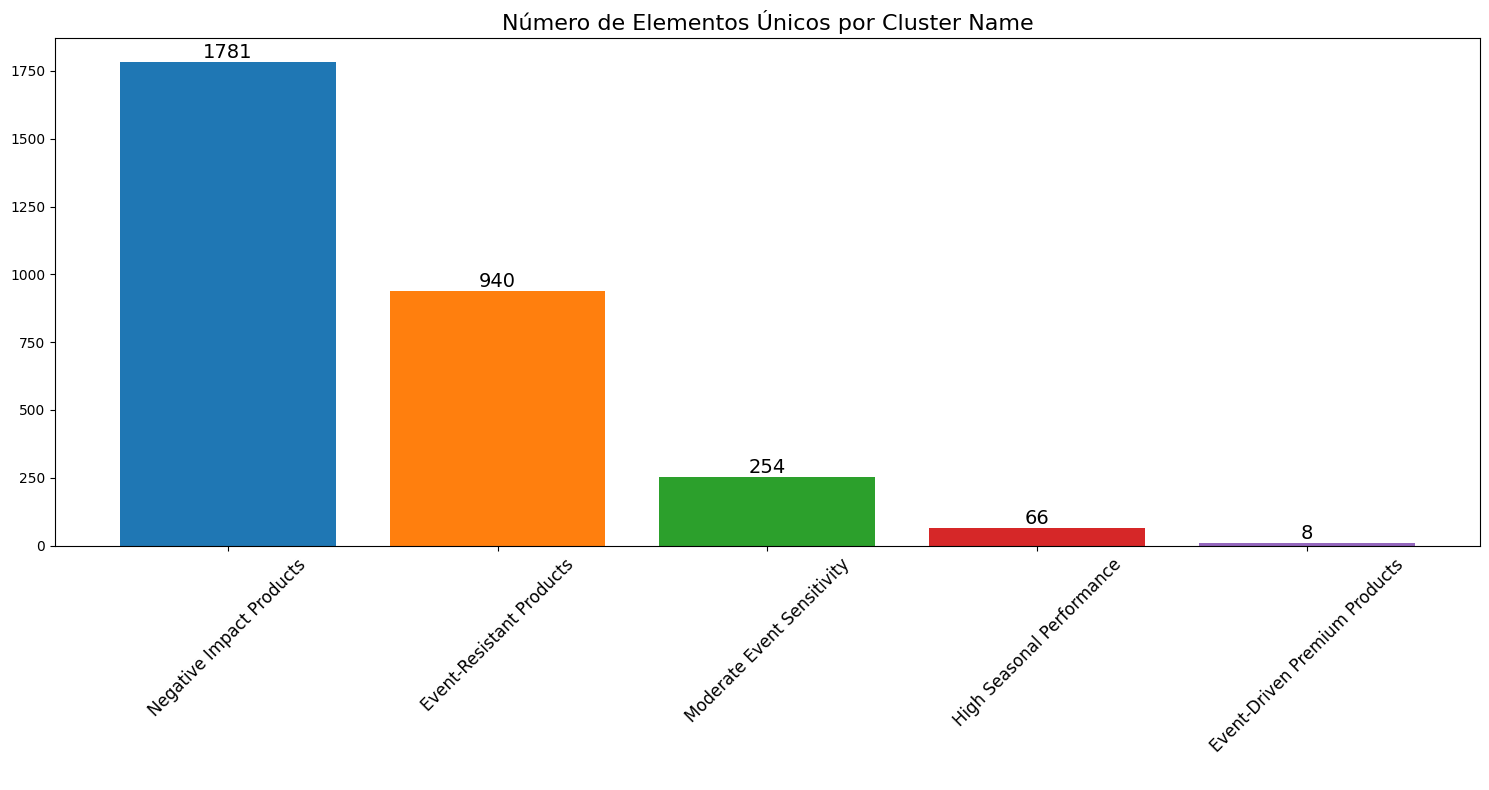

In [ ]:
km_m.plot_clusters_with_name(items_with_cluster_info)

## Guardamos CSV

In [ ]:
# Guardamos df como csv
from google.colab import files

file_name = 'items_clusters_events_influence_sales.csv'

# Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
items_with_cluster_info.to_csv(file_name, index=False)

# Descargar el archivo CSV
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

___
___